In [1]:
%%bash
# Extract raw data
tar -zxf ../raw_data/20190722.tar.gz -C ../raw_data

In [2]:
%matplotlib inline

# Import packages
import pandas as pd
import datetime as dt
import os

# Import user-defined module with regression and plotting functions
from src.calibrate import *

meas_day = "20190722"
data_directory = "../raw_data/"+meas_day+"/"

# Reformat measurement day to the format that GC uses
dt_day = dt.datetime.strptime(meas_day, "%Y%m%d")
gc_day = dt_day.strftime("%-m%d%Y")

infiles = os.listdir(data_directory)

# First create a pandas dataframe of peak table info from the GC 
# ascii files created during each individual sample run 
df = pd.DataFrame(columns=["sample", "N2O_peak", "CO2_peak", "CH4_peak"])

for file in infiles:
    sample = file # sample name
    peaks = get_peak_info(data_directory+file, CH4_check=0) # tuple of 3 peak areas
    
    df = df.append({"sample": sample, "N2O_peak": peaks[0], 
                                      "CO2_peak": peaks[1], 
                                      "CH4_peak": peaks[2]}, ignore_index=True)
pd.set_option('display.max_rows', 90)
# print(df)

In [3]:
# Create new dataframe with location, date, depth and vial number info
samples = sample_info_from_filename(df, 'sample')

# Drop the filename with incomplete information (Gas_PTC1-_20190610-H, Gas_PTC1-_20190610-H)
# samples = samples.drop([31, 32], axis=0)

# pd.set_option('display.max_rows', 90)
# print(samples)

In [4]:
# Get info from standards
stds = df[df['sample'].str.contains('Std')].copy()

# Get the std concentration from the sample name
stds['ppm'] = stds['sample'].str.extract(r'Std_(\d+)ppm')
stds['ppm'] = pd.to_numeric(stds['ppm']) # Convert to float

# Correct for N2O Std concentrations less than 1
i = stds.index[stds['sample'].str.match('N2OStd_05')]
stds.loc[i, ['ppm']] = 0.5
i = stds.index[stds['sample'].str.match('N2OStd_0101')]
stds.loc[i, ['ppm']] = 0.101

# Convert peaks to numeric
stds['N2O_peak'] = pd.to_numeric(stds['N2O_peak'])
stds['CO2_peak'] = pd.to_numeric(stds['CO2_peak'])
stds['CH4_peak'] = pd.to_numeric(stds['CH4_peak'])

print(stds)

                            sample  N2O_peak  CO2_peak  CH4_peak        ppm
0     CH4Std_100ppm_7222019_50.txt     46554   1557522    125905    100.000
1      CH4Std_10ppm_7222019_19.txt     39359   7171752     15882     10.000
2       CH4Std_2ppm_7222019_18.txt     49584    669640    500039      2.000
3    CH4Std_5030ppm_7222019_51.txt     33206   1161506   7234290   5030.000
4   CO2Std_10100ppm_7222019_62.txt     41100   2344833      2673  10100.000
5     CO2Std_1010ppm_7222019_2.txt     27194  19821158      2889   1010.000
6   CO2Std_50000ppm_7222019_63.txt     36981  55981322      4250  50000.000
7      CO2Std_500ppm_7222019_1.txt     26288   1404186      2633    500.000
44   N2OStd_0101ppm_7222019_33.txt     64823    743399      4606      0.101
45     N2OStd_05ppm_7222019_34.txt     89013    507384      5423      0.500
46     N2OStd_10ppm_7222019_69.txt    664699   1005637      4537     10.000
47      N2OStd_1ppm_7222019_35.txt    317747    371792      3484      1.000
48     N2OSt

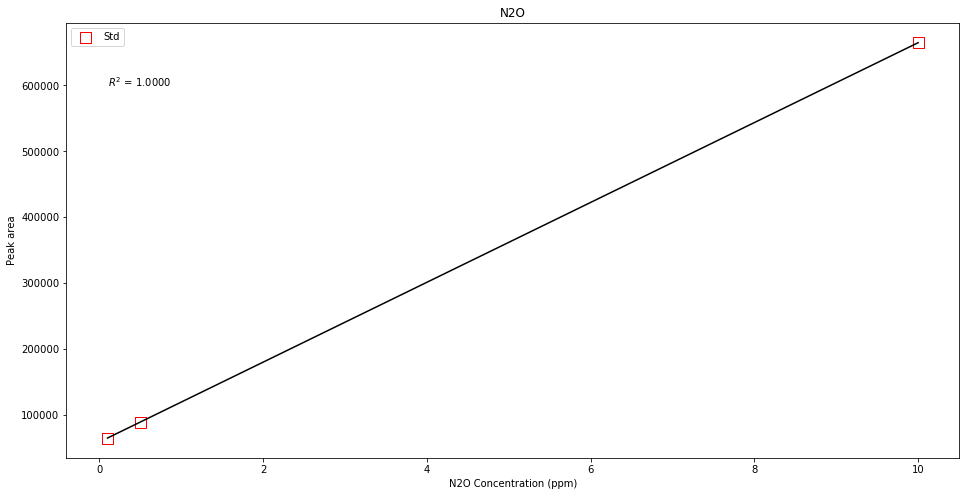

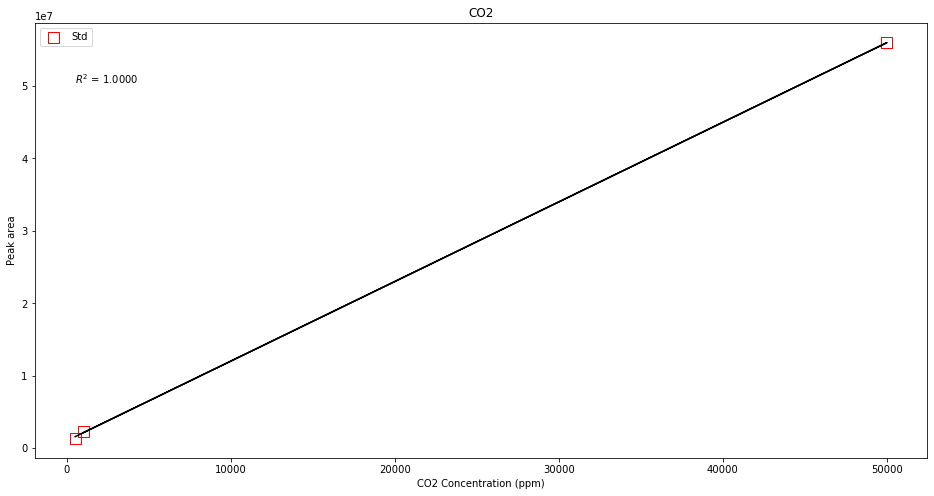

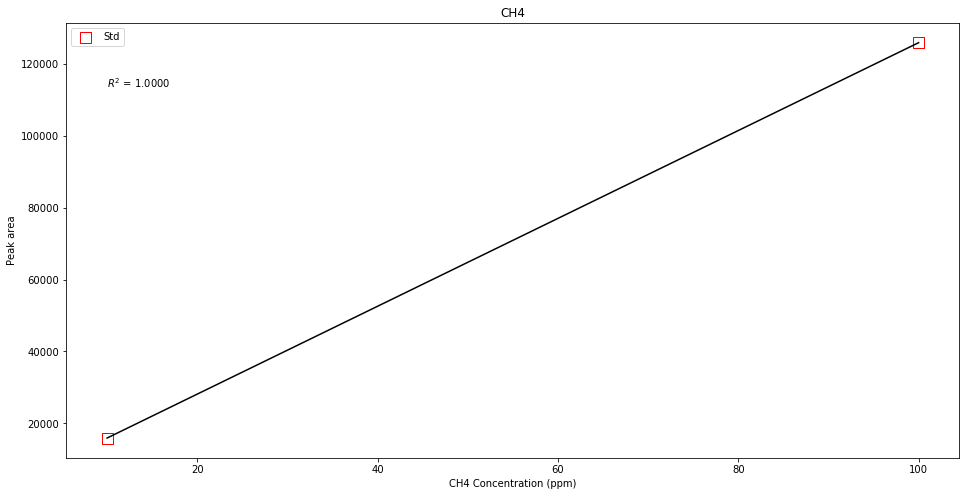

In [5]:
# Separate out N2O, CH4 and CO2 standards
N2Ostd  = stds[stds['sample'].str.contains("N2OStd")].copy()
CO2std  = stds[stds['sample'].str.contains("CO2Std")].copy()
CH4std  = stds[stds['sample'].str.contains("CH4Std")].copy()

# Play around with CH4 standard curve
CH4std = CH4std[~CH4std['sample'].str.contains('5030ppm')] # Drop 5000 ppm since no samples are above 10 ppm
CH4std = CH4std[~CH4std['sample'].str.contains('_2ppm')] # 2ppm looks absurdly high

# Play around with N2O standard curve 
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_80ppm')] # Drop 80 ppm since no samples are above 10 ppm
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_1ppm')] # Drop 1 ppm as well -- based on previous days, it may be high

# Play around with CO2 standard curve
CO2std.loc[5, 'ppm'] = 10100 # Coul the 1010ppm and 10100 ppm vials have been swapped?
CO2std.loc[4, 'ppm'] = 1010
CO2std = CO2std[~CO2std['sample'].str.contains('_1010ppm')]

# Plot the standards with linear regression trendline
plot_standards(N2Ostd['ppm'],N2Ostd['N2O_peak'],"N2O")
plot_standards(CO2std['ppm'],CO2std['CO2_peak'],"CO2")
plot_standards(CH4std['ppm'],CH4std['CH4_peak'],"CH4")

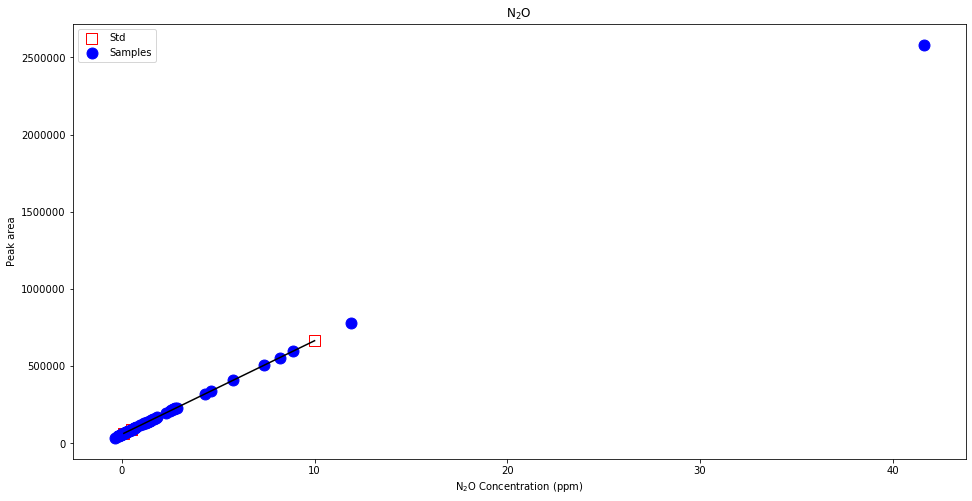

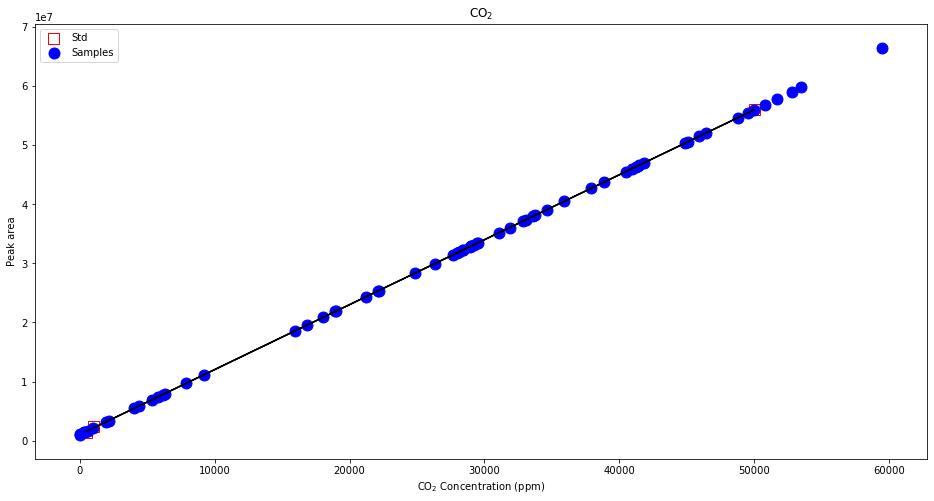

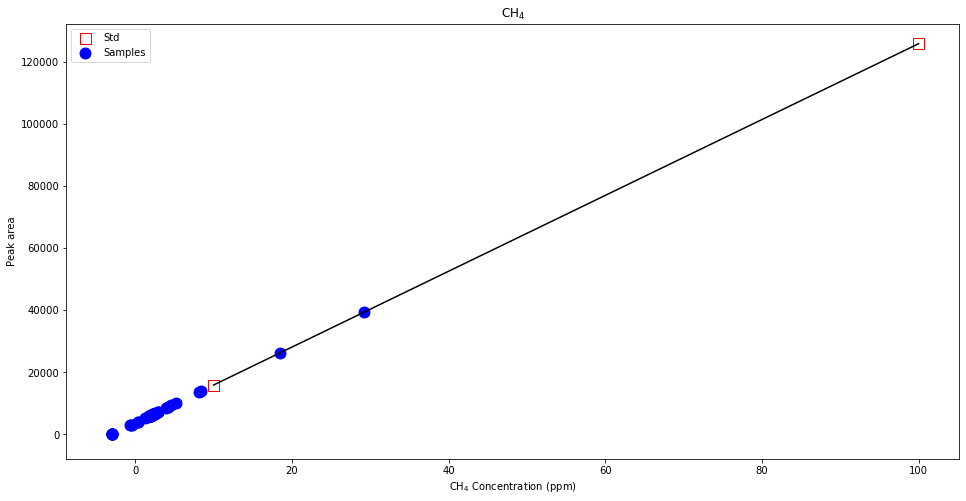

In [6]:
# Now, plot the standards along with the samples
plot_samples(samples['N2O_peak'], N2Ostd['ppm'], N2Ostd['N2O_peak'], "N$_2$O")
plot_samples(samples['CO2_peak'], CO2std['ppm'], CO2std['CO2_peak'], "CO$_2$")
plot_samples(samples['CH4_peak'], CH4std['ppm'], CH4std['CH4_peak'], "CH$_4$")

In [8]:
# Since the data look good, export the sample concentrations to a text file
saveoutput = save_sampleconc_new(N2Ostd['ppm'], N2Ostd['N2O_peak'], 
                                 CO2std['ppm'], CO2std['CO2_peak'], 
                                 CH4std['ppm'], CH4std['CH4_peak'], 
                                 samples, "../processed_data/RVT_TracerTest_GasConcentrations_20190722.txt", 
                                 write_to_datafile=False)

# Correct for single high sample (PTT3-120 cm; vial 21) now that we've 
# removed 80 ppm standard. Calculated N2O was 51.292233 ppm with the 
# 80ppm standard included in the standard curve
i = saveoutput.index[saveoutput['vial'] == '21']
saveoutput.loc[i, 'N2O_conc'] = 51.292233

# To manually export to CSV, uncomment the line below
saveoutput.to_csv("../processed_data/RVT_TracerTest_GasConcentrations_20190722.txt", mode='w', sep="\t", index=False, header=False, na_rep='NaN')

print(saveoutput)

   vial    location depth       date method    dup   N2O_conc  N2O_bdl  \
8    78  Atmosphere     0 2019-06-03      G  False   0.259924    False   
9    77  Atmosphere     0 2019-06-10      G  False   0.128882    False   
10   60        NTC1   110 2019-06-10      H  False   0.601480    False   
11   61        NTC1   140 2019-06-10      H  False   0.729897    False   
12   57        NTC1    20 2019-06-10      H  False   0.050500     True   
13   52        PTC2    30 2019-06-10      G  False   0.050500     True   
14   24        PTC2    60 2019-06-03      G  False   0.574598    False   
15   53        PTC2    60 2019-06-10      H  False   0.050500     True   
16   25        PTC2    90 2019-06-03      G  False   0.622124    False   
17   54        PTC2    90 2019-06-10      H  False   0.050500     True   
18   31        PTT0   120 2019-06-10      H  False   0.554416    False   
19   32        PTT0   150 2019-06-10      H  False   1.812157    False   
20   28        PTT0    30 2019-06-10  